In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scipy.optimize
import pysimul
import time
from math import *
π = np.pi

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
path = "langevin4"

In [2]:
path = None

In [3]:
realizations = []
params = {
    't_end': 1,
    't_beg': 0,
    'target_T': 10,
    'gamma': 100,
    'part_m': 10,
    'cont_r': 0.5,
}
if path is not None:
    pd.DataFrame(list(params.items())).set_index(0).to_csv(path+"/params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')

In [35]:
for _ in range(9):
    simul = pysimul.PySimul()
    simul['t_pause'] = params['t_end']+0.01
    simul['T'] = params['target_T']
    simul['gamma'] = params['gamma']
    simul['well_k'] = 0
    simul.start()
    while not simul['pause']:
        simul.sfml_event_poll()
        time.sleep(0.01)
    d = {
        't': simul['sample_t'],
        'x': simul['part_x']-0.5,
        'y': simul['part_y']-0.5,
        'vx': simul['part_vx'],
        'vy': simul['part_vy'],        
        't_beg_exact': 0
    }
    params['Delta_t'] = simul['Delta_t']
    realizations.append(d)
    simul.end()

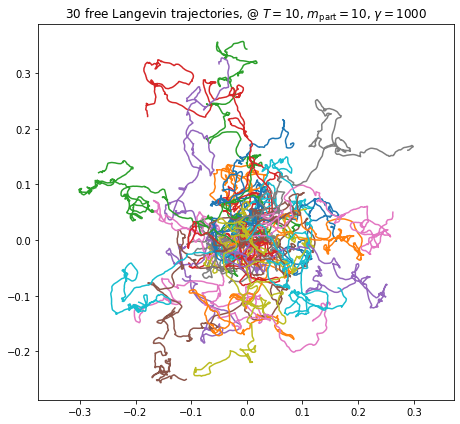

In [36]:
plt.figure(figsize=(6.5,6))
for rea in realizations:
    plt.plot(rea['x'], rea['y'])
plt.axis('equal')
plt.title("{} free Langevin trajectories, @ $T={}$, $m_\operatorname{{part}}={}$, $\gamma={}$".format(len(realizations), params['target_T'], params['part_m'], params['gamma']))
plt.tight_layout()
if path is not None:
    plt.savefig(path+"/spaghettis.pdf")

In [6]:
# Assumptions here : x(0) = y(0) = vx(0) = vy(0) = 0, uniform trajectory length

N_samples = 150
t = np.linspace(0, params['t_end'], N_samples)
samples_t_i = [30, 75, 120]
samples_acc_R2 = []
samples_acc_dir = []
R2 = np.zeros(N_samples)
R2std = np.zeros(N_samples)
V2 = np.zeros(N_samples)
V2std = np.zeros(N_samples)
mass_center_x = np.zeros(N_samples)
mass_center_y = np.zeros(N_samples)
acc_R2 = np.zeros(len(realizations))
acc_dir = np.zeros(len(realizations))
acc_V2 = np.zeros(len(realizations))
for i in range(N_samples):
    record_sample = (i in samples_t_i)
    mass_center_x_acc, mass_center_y_acc = 0,0
    j = 0
    for rea in realizations:
        k = np.searchsorted(rea['t'], rea['t_beg_exact']+t[i], side='right')
        x, y = rea['x'][k], rea['y'][k]
        mass_center_x_acc += x
        mass_center_y_acc += y
        acc_R2[j] = x**2 + y**2
        if record_sample:
            acc_dir[j] = atan2( y, x )
        acc_V2[j] = (rea['vx'][k])**2 + (rea['vy'][k])**2
        j += 1
    if record_sample:
        samples_acc_R2.append(np.copy(acc_R2))
        samples_acc_dir.append(np.copy(acc_dir))
    mass_center_x[i] = mass_center_x_acc/len(realizations)
    mass_center_y[i] = mass_center_y_acc/len(realizations)
    R2[i] = np.mean(acc_R2)
    R2std[i] = np.std(acc_R2)
    V2[i] = np.mean(acc_V2)
    V2std[i] = np.std(acc_V2)

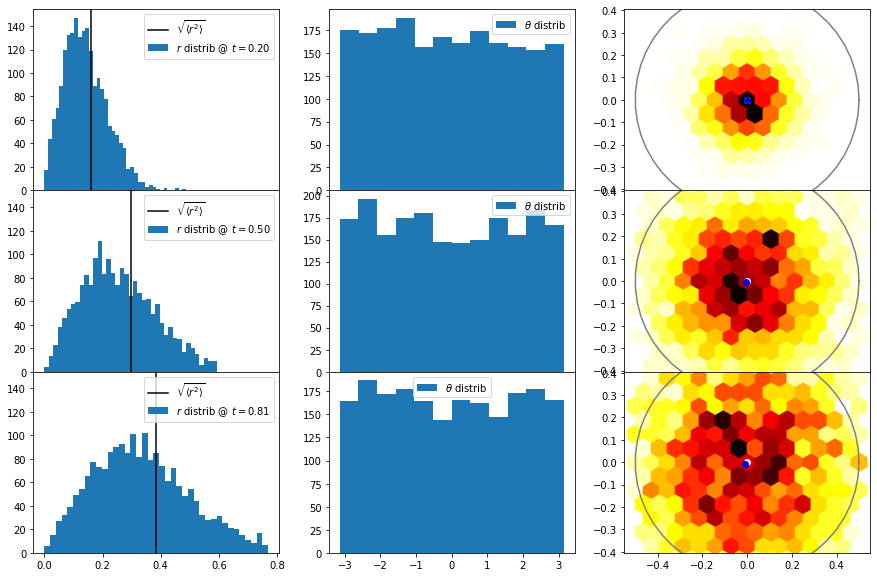

In [7]:
fig, axes = plt.subplots(nrows=len(samples_t_i), ncols=3, sharex='col', figsize=(15,10))
fig.subplots_adjust(hspace=0)
for j in range(len(samples_t_i)):
    axes[j][0].hist(np.sqrt(samples_acc_R2[j]), bins=np.linspace(0,max(0.5,2*sqrt(R2[samples_t_i[j]])),40), label=r"$r$ distrib @ $t={:.2f}$".format(t[samples_t_i[j]]))
    axes[j][0].axvline(x=sqrt(R2[samples_t_i[j]]), label=r"$\sqrt{\langle r^2\rangle}$", color='black')
    if j != 0:
        axes[j][0].set_ylim(axes[0][0].get_ylim())
    axes[j][0].legend()
    axes[j][1].hist(samples_acc_dir[j], bins=12, label=r"$\theta$ distrib")
    axes[j][1].legend()
    acc_x = np.sqrt(samples_acc_R2[j]) * np.cos(samples_acc_dir[j])
    acc_y = np.sqrt(samples_acc_R2[j]) * np.sin(samples_acc_dir[j])
    center_x = np.mean(acc_x)
    center_y = np.mean(acc_y)
    axes[j][2].hexbin(acc_x, acc_y, gridsize=14, extent=(-0.5,+0.5,-0.5,+0.5), cmap='hot_r')
    u = np.linspace(0,2*np.pi,50)
    axes[j][2].plot(params['cont_r']*np.cos(u), params['cont_r']*np.sin(u), color='grey')
    axes[j][2].scatter([0],[0], color='white', label="center")
    axes[j][2].scatter([center_x],[center_y], color='blue', label="distrib center")
    axes[j][2].axis('equal')
if path is not None:
    plt.savefig(path+"/distribs_r_theta.pdf")

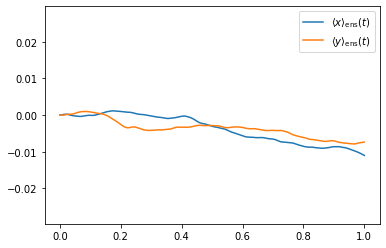

In [8]:
plt.plot(t, mass_center_x, label=r"$\langle x \rangle_\operatorname{ens}(t)$")
plt.plot(t, mass_center_y, label=r"$\langle y \rangle_\operatorname{ens}(t)$")
plt.ylim((-sqrt(R2[samples_t_i[1]])/10,+sqrt(R2[samples_t_i[1]])/10))
plt.legend()
None

fit : D = 0.0507 ± 3.6%


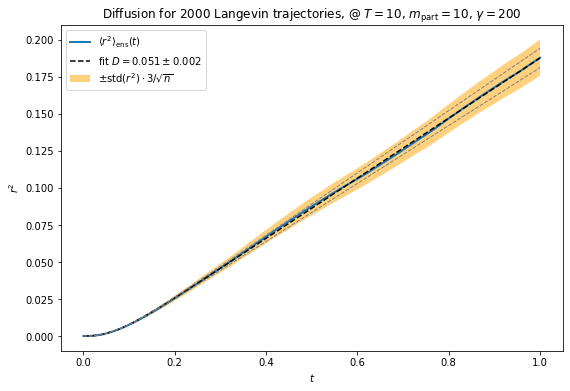

In [9]:
m = params['part_m']
diffus_curve = lambda t,tau,T: 4*T/m*tau * ( t -2*tau*(1-np.exp(-t/tau)) + tau/2*(1-np.exp(-2*t/tau)) )
p0 = (m/params['gamma'], params['target_T'])
R2_err = 3 * R2std / sqrt(len(realizations))
_coeff, _cov = scipy.optimize.curve_fit( diffus_curve, t, R2, p0=p0, sigma=1.5*R2_err, absolute_sigma=True, bounds=([p0[0]*0.5,p0[1]*0.5],[p0[0]*1.5,p0[1]*1.5]) )
diffus_tau = _coeff[0]
diffus_tau_err = sqrt(np.diag(_cov)[0])
diffus_T = _coeff[1]
diffus_T_err = sqrt(np.diag(_cov)[1])

D = diffus_T/m*diffus_tau
D_err = D * (diffus_tau_err/diffus_tau + diffus_T_err/diffus_T)

plt.figure(figsize=(9,6))
ax1 = plt.gca()
ax1.fill_between(t, R2-R2_err, R2+R2_err, facecolor='orange', alpha=0.5, label=r"$\pm \operatorname{std}(r^2)\cdot 3/\sqrt{n}$")
ax1.plot(t, R2, label=r"$\langle r^2 \rangle_\operatorname{ens}(t)$", lw=2)
ax1.plot(t, diffus_curve(t,diffus_tau,diffus_T), '--', color='black', label=r"fit $D={:.3f}\pm{:.3f}$".format(D,D_err))
ax1.plot(t, diffus_curve(t,diffus_tau-diffus_tau_err,diffus_T-diffus_T_err), '--', color='grey', lw=1)
ax1.plot(t, diffus_curve(t,diffus_tau+diffus_tau_err,diffus_T+diffus_T_err), '--', color='grey', lw=1)
ax1.legend()
ax1.set_xlabel("$t$")
ax1.set_ylabel("$r^2$")
plt.title("Diffusion for {} Langevin trajectories, @ $T={}$, $m_\operatorname{{part}}={}$, $\gamma={}$".format(len(realizations), params['target_T'], params['part_m'], params['gamma']))
if path is not None:
    plt.savefig(path+"/diffus_fit.pdf")

print("fit : D = {:.4f} ± {:.1f}%".format(D,D_err/D*100))

D_th = 0.0500


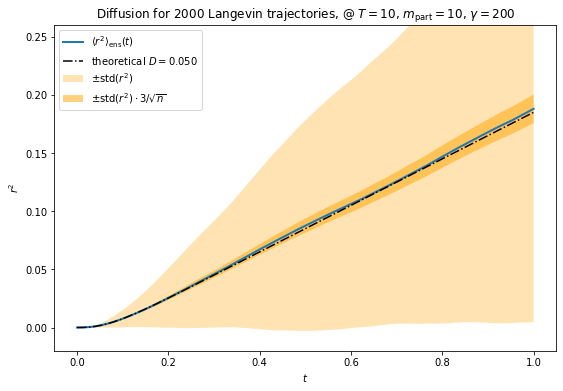

In [10]:
D_th = params['target_T']/params['gamma']

plt.figure(figsize=(9,6))
ax1 = plt.gca()
ax1.fill_between(t, R2-R2std, R2+R2std, facecolor='orange', alpha=0.3, label=r"$\pm \operatorname{std}(r^2)$")
ax1.fill_between(t, R2-R2_err, R2+R2_err, facecolor='orange', alpha=0.5, label=r"$\pm \operatorname{std}(r^2)\cdot 3/\sqrt{n}$")
ax1.plot(t, R2, label=r"$\langle r^2 \rangle_\operatorname{ens}(t)$", lw=2)
ax1.plot(t, diffus_curve(t, m/params['gamma'], params['target_T']), '-.', color='black', label=r"theoretical $D={:.3f}$".format(D_th))
ax1.legend()
ax1.set_ylim((-np.max(R2+R2_err)*0.1,np.max(R2+R2_err)*1.3))

ax1.set_xlabel("$t$")
ax1.set_ylabel("$r^2$")
plt.title("Diffusion for {} Langevin trajectories, @ $T={}$, $m_\operatorname{{part}}={}$, $\gamma={}$".format(len(realizations), params['target_T'], params['part_m'], params['gamma']))
if path is not None:
    plt.savefig(path+"/diffus_th.pdf")

print("D_th = {:.4f}".format(D_th))

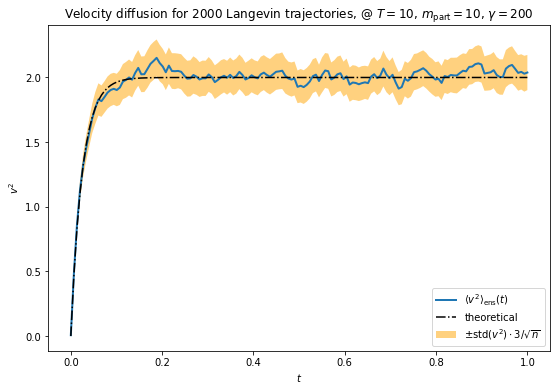

In [11]:
diffus_v_curve = lambda t,γ,T: 2*T/m * ( 1-np.exp(-2*γ*t/m) )
V2_err = 3 * V2std / sqrt(len(realizations))

plt.figure(figsize=(9,6))
ax1 = plt.gca()
ax1.fill_between(t, V2-V2_err, V2+V2_err, facecolor='orange', alpha=0.5, label=r"$\pm \operatorname{std}(v^2)\cdot 3/\sqrt{n}$")
ax1.plot(t, V2, label=r"$\langle v^2 \rangle_\operatorname{ens}(t)$", lw=2)
ax1.plot(t, diffus_v_curve(t,params['gamma'],params['target_T']), '-.', color='black', label="theoretical")
ax1.legend()
ax1.set_xlabel("$t$")
ax1.set_ylabel("$v^2$")
plt.title("Velocity diffusion for {} Langevin trajectories, @ $T={}$, $m_\operatorname{{part}}={}$, $\gamma={}$".format(len(realizations), params['target_T'], params['part_m'], params['gamma']))
if path is not None:
    plt.savefig(path+"/diffus_v.pdf")

In [12]:
pd.DataFrame({
    't': t,
    'R2': R2,
    'R2std': R2std
}).to_csv(path+"/R2_t.csv", index=False, float_format='%.5f')

pd.DataFrame(list({
    'N_traj': len(realizations),
    'T_mean': params['target_T'],
    'T_err': 0,
    'D': D,
    'D_err': D_err,
    'D_th': D_th,
    'name': path
}.items())).set_index(0).to_csv(path+"/diffus.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
path+"/diffus.csv"

'langevin3/diffus.csv'

---

In [4]:
simul = pysimul.PySimul()
simul['t_pause'] = simul_time = 200
simul['T'] = kBT = params['target_T']
simul['gamma'] = γ = params['gamma']
simul['well_k'] = k = 1e4
m = params['part_m']
simul.start()
while not simul['pause']:
    simul.sfml_event_poll()
    time.sleep(0.01)
t = simul['sample_t']
part_x = simul['part_x']-0.5
part_y = simul['part_y']-0.5
part_vx = simul['part_vx']
part_vy = simul['part_vy']
(acc, samples) = simul["xdist"]
xdist = acc/samples
xdist_max = simul["xdist_max"]
(acc, samples) = simul["rdist"]
rdist = acc/samples
params['Delta_t'] = simul['Delta_t']
T_part = simul['part_T']/simul['part_T_samples']
simul.end()

In [5]:
T_well_x = 2 * np.mean( k/2 * part_x**2 )
T_well_y = 2 * np.mean( k/2 * part_y**2 )
T_well = (T_well_x + T_well_y)/2
T_well_x, T_well_y

(10.106593757046682, 10.372030681315685)

In [6]:
T_part_x = 2 * np.mean( params["part_m"]/2 * part_vx**2 )
T_part_y = 2 * np.mean( params["part_m"]/2 * part_vy**2 )
T_part_x, T_part_y, T_part

(10.247045807808687, 10.297169097064522, 10.27212036026388)

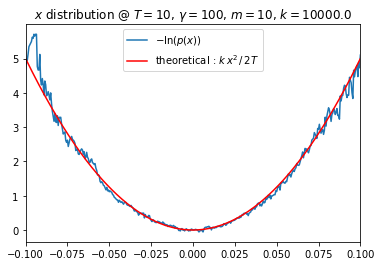

In [7]:
x = np.linspace(-xdist_max,xdist_max,len(xdist))
with np.errstate(divide='ignore'):
    U_kT = -np.log(xdist)
U_kT -= U_kT[len(x)//2]
plt.plot(x, U_kT, label=r"$-\ln(p(x))$")
plt.xlim((-xdist_max,xdist_max))
plt.plot(x, k/2*x**2/kBT, color='red', label=r"theoretical : $k\,x^2\,/\,2T$")
plt.legend()
plt.title(r"$x$ distribution @ $T={}$, $\gamma={}$, $m={}$, $k={}$".format(params['target_T'],params['gamma'],params['part_m'],k))
if path is not None:
    plt.savefig(path+"/xdistrib-pot.pdf")

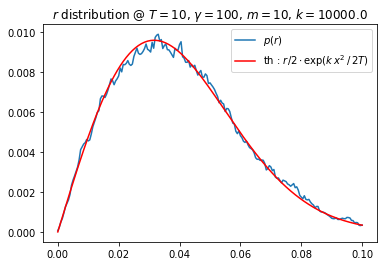

In [8]:
r = np.linspace(0,xdist_max,len(rdist))
plt.plot(r, rdist, label="$p(r)$")
plt.plot(r, r/2*np.exp(-k/2*r**2/kBT), color='red', label=r"th : $r/2\cdot\exp(k\,x^2\,/\,2T)$")
plt.legend()
plt.title(r"$r$ distribution @ $T={}$, $\gamma={}$, $m={}$, $k={}$".format(params['target_T'],params['gamma'],params['part_m'],k))
if path is not None:
    plt.savefig(path+"/rdistrib.pdf")

In [9]:
def psd (t, x):
    ft = np.fft.rfft(x)
    Δt = t[1]-t[0]
    f = np.fft.rfftfreq(len(t), d=Δt)
    psd = ft.imag**2 + ft.real**2
    return f, psd*Δt/len(t)

La normalisation de la transformée de Fourier de `np.fft` est la même que celle usuellement utilisée pour la PSD ($\times 1$ pour la FT, $\times \frac{1}{N}$ pour la IFT)

In [10]:
f,psd_x = psd(t, part_x)
f,psd_y = psd(t, part_y)
psd_xy = (psd_x+psd_y)/2

In [11]:
psd_exact_form = lambda f,g,γ: g/((k-m*(2*π*f)**2)**2 + (2*π*f*γ)**2)
g = 2 * kBT * γ

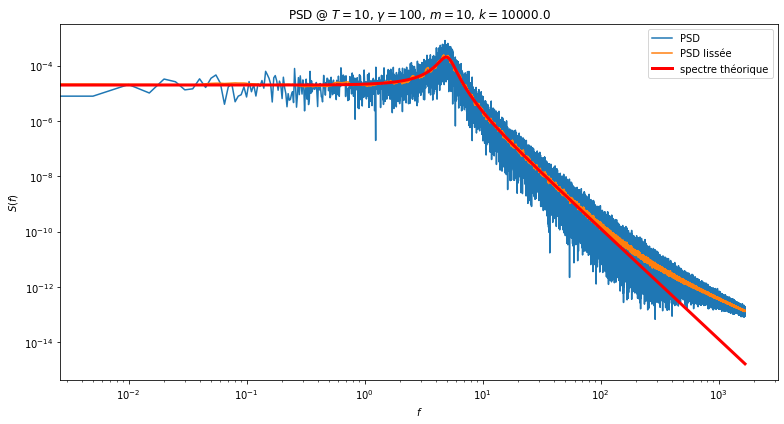

In [12]:
fig, ax = plt.subplots(1,1, figsize=(11,6))
ss = len(f)//4
ax.loglog(f[:ss], psd_xy[:ss], label="PSD")
ax.loglog(f[:ss], pysimul.cma(psd_xy[:ss],20), label="PSD lissée")
ax.loglog(f[:ss], psd_exact_form(f,g,γ)[:ss], label="spectre théorique", color='red', lw=3)
ax.legend()
ax.set_xlabel("$f$")
ax.set_ylabel("$S(f)$")
ax.set_title(r"PSD Langevin @ $T={}$, $\gamma={}$, $m={}$, $k={}$".format(params['target_T'],params['gamma'],params['part_m'],k))
fig.tight_layout()
if path is not None:
    plt.savefig(path+"/psd-fit.pdf")
    plt.savefig(path+"/psd-fit.png")